<a href="https://colab.research.google.com/github/rgrion/mlarrozprevisao/blob/main/Experimentos_Preliminares/Treinamento_Top_2011_a_2020_3anos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Lista de anos e dicionário para armazenar
anos = list(range(2011, 2024))
dados_por_ano = {}

for ano in anos:
    df = pd.read_csv(f'/content/Top_Rice_{ano}.csv')
    df = df[['Area', 'Year', 'Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)']].dropna()
    dados_por_ano[ano] = df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

resultados = []

# Dataset de treino
df_treino = pd.concat([
    dados_por_ano[2011], dados_por_ano[2012], dados_por_ano[2013], dados_por_ano[2014], dados_por_ano[2015],
    dados_por_ano[2016], dados_por_ano[2017], dados_por_ano[2018], dados_por_ano[2019], dados_por_ano[2020],
])
paises = df_treino['Area'].unique()

# Loop de previsão
for ano in range(2021, 2024):
    df_real = dados_por_ano[ano]

    for pais in paises:
        try:
            df_pais_treino = df_treino[df_treino['Area'] == pais]
            df_pais_real = df_real[df_real['Area'] == pais]

            if len(df_pais_treino) < 2 or df_pais_real.empty:
                continue

            # Dados de treino e predição
            X_train = df_pais_treino[['Year', 'Area harvested (ha)']]
            y_train = df_pais_treino['Production (t)']

            area_pred = df_pais_real['Area harvested (ha)'].values[0]
            X_pred = pd.DataFrame({'Year': [ano], 'Area harvested (ha)': [area_pred]})

            # Treinamento dos modelos
            lr = LinearRegression().fit(X_train, y_train)
            xgb = XGBRegressor(objective='reg:squarederror', n_estimators=50).fit(X_train, y_train)

            # Normalização para SVR
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_pred_scaled = scaler.transform(X_pred)

            svr = SVR(kernel='rbf', C=100, gamma=0.1).fit(X_train_scaled, y_train)

            # Previsões
            pred_lr = lr.predict(X_pred)[0]
            pred_xgb = xgb.predict(X_pred)[0]
            pred_svr = svr.predict(X_pred_scaled)[0]

            prod_real = df_pais_real['Production (t)'].values[0]

            resultados.append({
                'Area': pais,
                'Ano_Previsto': ano,
                'Production_Real': prod_real,
                'Prod_LR': pred_lr,
                'Prod_XGB': pred_xgb,
                'Prod_SVR': pred_svr
            })

        except Exception as e:
            print(f'Erro com país {pais} no ano {ano}: {e}')

In [ ]:
# Converter a lista em DataFrame
df_resultado = pd.DataFrame(resultados)

# Calcular erros absolutos e percentuais para cada modelo
for modelo in ['LR', 'XGB', 'SVR']:
    df_resultado[f'Erro_Abs_Prod_{modelo}'] = abs(df_resultado[f'Prod_{modelo}'] - df_resultado['Production_Real'])
    df_resultado[f'Erro_%_Prod_{modelo}'] = 100 * df_resultado[f'Erro_Abs_Prod_{modelo}'] / df_resultado['Production_Real']

# Definir formato com duas casas decimais
pd.set_option('display.float_format', '{:,.2f}'.format)

# Exibir tabela ordenada por país e ano
display(df_resultado[['Area', 'Ano_Previsto',
                      'Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR',
                      'Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']]
        .sort_values(by=['Area', 'Ano_Previsto'])
        .round(2))

,Area,Ano_Previsto,Production_Real,Prod_LR,Prod_XGB,Prod_SVR,Erro_%_Prod_LR,Erro_%_Prod_XGB,Erro_%_Prod_SVR
0,Bangladesh,2021,"56,383,442.00","56,738,265.53","54,905,272.00","51,806,264.00",0.63,2.62,8.12
13,Bangladesh,2022,"57,189,193.00","57,204,385.81","54,905,272.00","51,806,261.81",0.03,3.99,9.41
26,Bangladesh,2023,"58,613,458.00","57,453,615.99","54,905,272.00","51,806,259.80",1.98,6.33,11.61
1,Cambodia,2021,"12,207,000.00","12,245,335.36","10,935,823.00","9,671,329.67",0.31,10.41,20.77
14,Cambodia,2022,"11,624,000.00","11,296,052.97","10,935,823.00","9,671,394.31",2.82,5.92,16.80
27,Cambodia,2023,"12,900,000.00","12,882,446.74","10,935,823.00","9,671,239.58",0.14,15.23,25.03
2,China,2021,"214,403,870.05","214,762,078.97","211,424,160.00","212,043,529.99",0.17,1.39,1.10
15,China,2022,"210,070,800.06","213,565,538.27","211,424,160.00","212,043,470.34",1.66,0.64,0.94
28,China,2023,"208,064,200.06","212,045,602.78","211,424,160.00","212,043,433.36",1.91,1.61,1.91
3,"China, Hong Kong SAR",2021,0.05,0.05,0.06,0.06,8.00,17.65,10.00


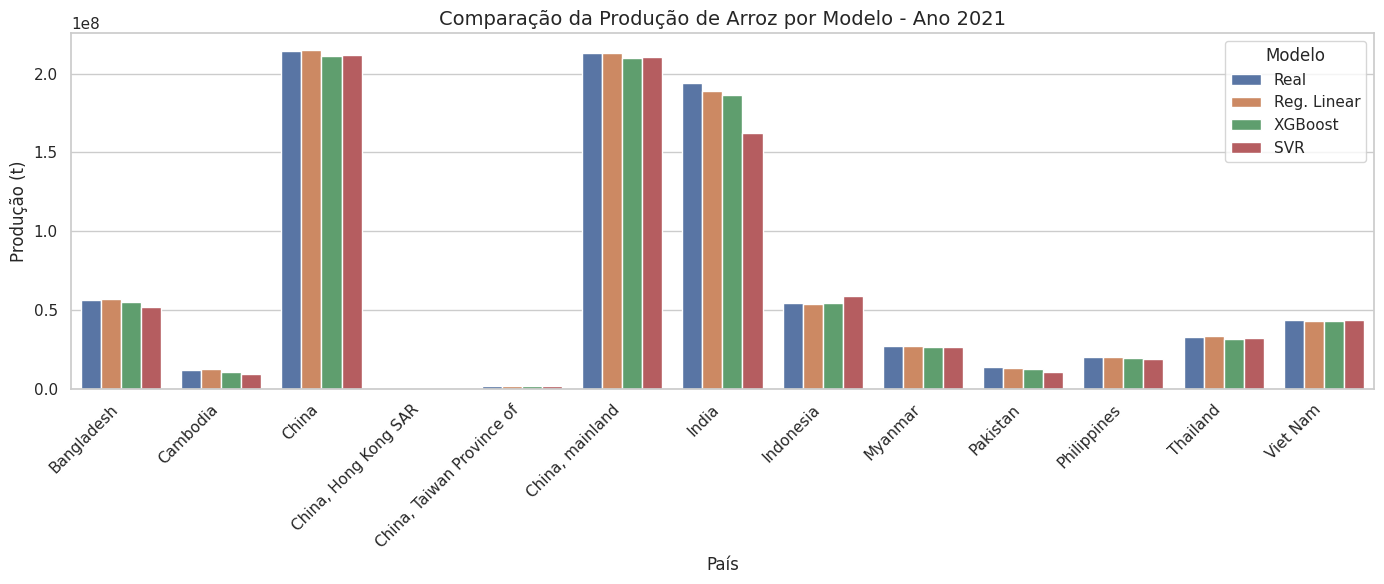

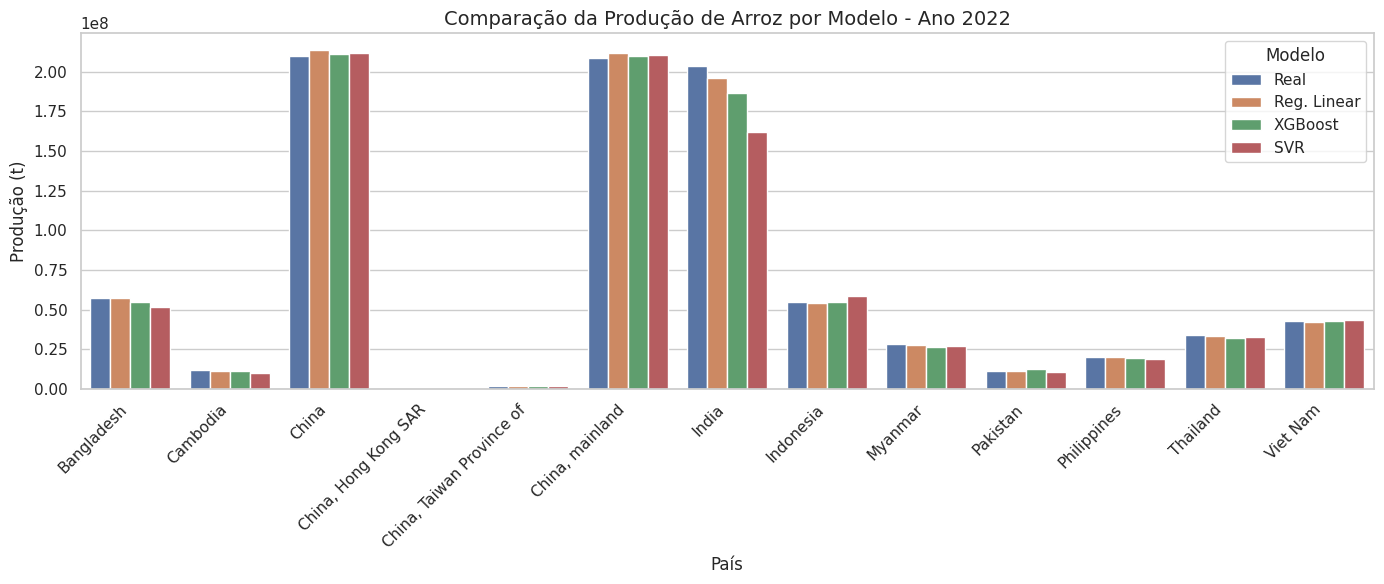

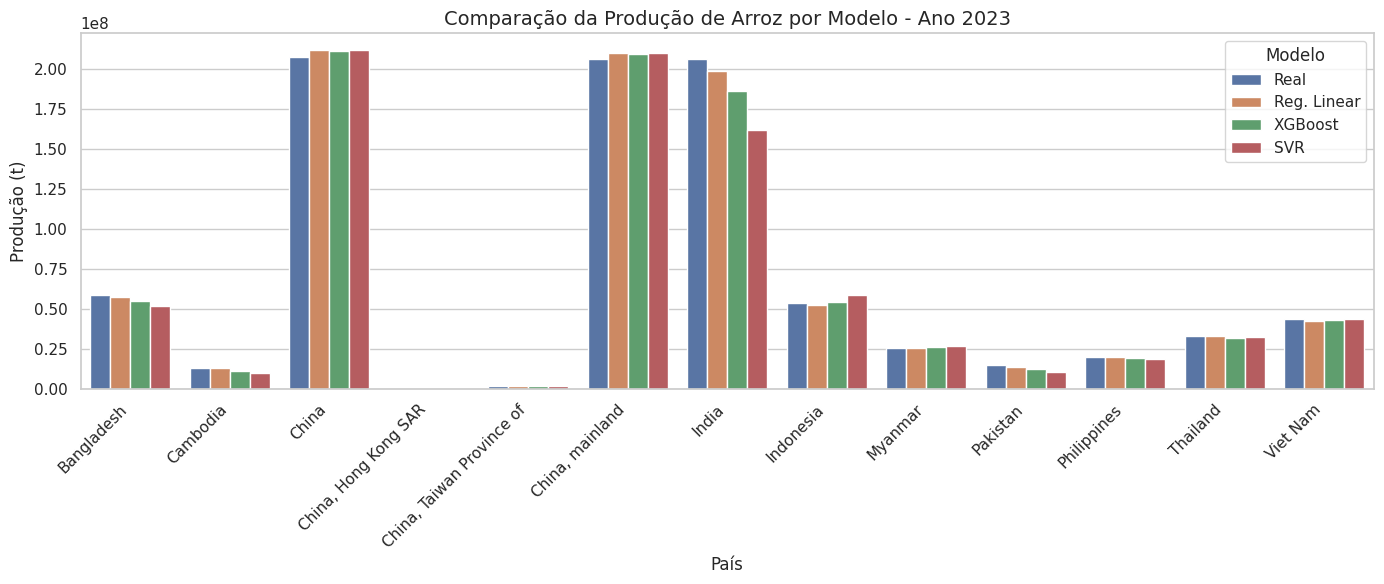

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Garantir estilo bonito
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Loop para um gráfico por ano
anos_previstos = sorted(df_resultado['Ano_Previsto'].unique())

for ano in anos_previstos:
    df_ano = df_resultado[df_resultado['Ano_Previsto'] == ano].copy()

    # Reformata para gráfico de barras agrupadas
    df_plot = pd.melt(df_ano,
                      id_vars='Area',
                      value_vars=['Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR'],
                      var_name='Modelo',
                      value_name='Produção')

    # Renomear para legenda mais limpa
    df_plot['Modelo'] = df_plot['Modelo'].replace({
        'Production_Real': 'Real',
        'Prod_LR': 'Reg. Linear',
        'Prod_XGB': 'XGBoost',
        'Prod_SVR': 'SVR'
    })

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=df_plot, x='Area', y='Produção', hue='Modelo')
    plt.title(f'Comparação da Produção de Arroz por Modelo - Ano {ano}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Produção (t)')
    plt.xlabel('País')
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

In [ ]:
media_por_ano = df_resultado.groupby('Ano_Previsto')[
    ['Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR']
].mean().reset_index()


media_erro_por_ano = df_resultado.groupby('Ano_Previsto')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index()

print("Média da produção e previsões por ano:")
print(media_por_ano)

print("\nMédia dos erros percentuais por ano:")
print(media_erro_por_ano)

Média da produção e previsões por ano:
   Ano_Previsto  Production_Real       Prod_LR      Prod_XGB      Prod_SVR
0          2021    68,017,266.09 67,502,899.49 66,375,364.00 64,490,619.67
1          2022    67,872,357.51 67,761,127.97 66,375,364.00 64,490,611.14
2          2023    68,110,138.07 67,792,457.82 66,328,392.00 64,490,583.49

Média dos erros percentuais por ano:
   Ano_Previsto  Erro_%_Prod_LR  Erro_%_Prod_XGB  Erro_%_Prod_SVR
0          2021            2.46             5.57             8.61
1          2022            3.11             4.68             7.18
2          2023            3.82             6.41            10.67


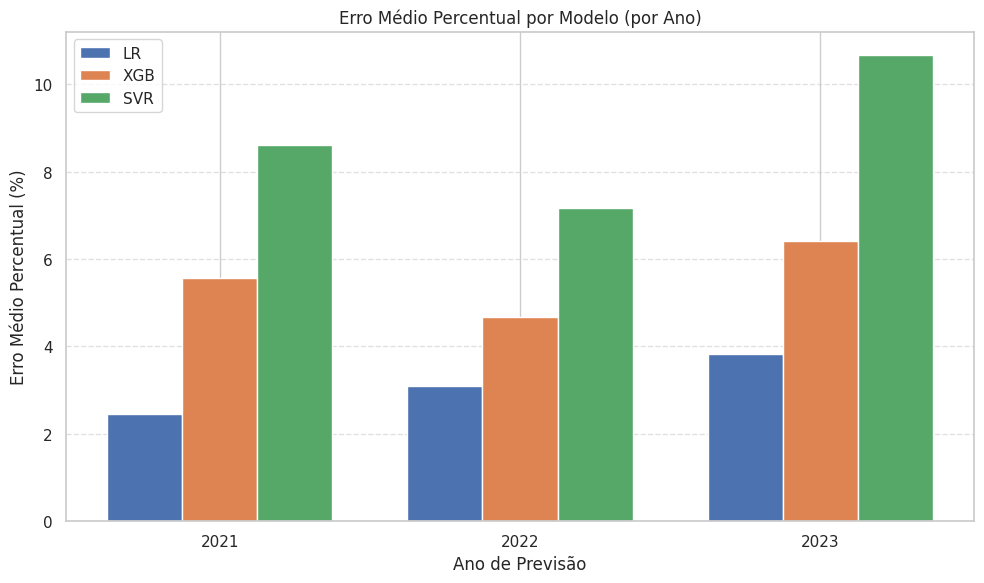

In [ ]:
import matplotlib.pyplot as plt

# Supondo que você já tenha o DataFrame `media_erro_por_ano`
plt.figure(figsize=(10, 6))

# Plotando as barras lado a lado por modelo
largura = 0.25
anos = media_erro_por_ano['Ano_Previsto']
x = range(len(anos))

plt.bar([p - largura for p in x], media_erro_por_ano['Erro_%_Prod_LR'], width=largura, label='LR')
plt.bar(x, media_erro_por_ano['Erro_%_Prod_XGB'], width=largura, label='XGB')
plt.bar([p + largura for p in x], media_erro_por_ano['Erro_%_Prod_SVR'], width=largura, label='SVR')

# Eixos e rótulos
plt.xticks(x, anos)
plt.ylabel('Erro Médio Percentual (%)')
plt.xlabel('Ano de Previsão')
plt.title('Erro Médio Percentual por Modelo (por Ano)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [ ]:
# Calcular média dos erros percentuais por país
media_erro_por_pais = df_resultado.groupby('Area')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index().sort_values(by='Area')

# Exibir o resultado
print("Média dos erros percentuais por país:")
print(media_erro_por_pais.round(2))

Média dos erros percentuais por país:
                         Area  Erro_%_Prod_LR  Erro_%_Prod_XGB  \
0                  Bangladesh            0.88             4.31   
1                    Cambodia            1.09            10.52   
2                       China            1.25             1.22   
3        China, Hong Kong SAR            8.42             7.19   
4   China, Taiwan Province of           13.52            14.36   
5             China, mainland            1.17             1.17   
6                       India            3.38             7.37   
7                   Indonesia            1.79             0.62   
8                     Myanmar            1.01             3.06   
9                    Pakistan            4.85            13.12   
10                Philippines            0.78             3.32   
11                   Thailand            0.74             4.48   
12                   Viet Nam            1.80             1.47   

    Erro_%_Prod_SVR  
0              

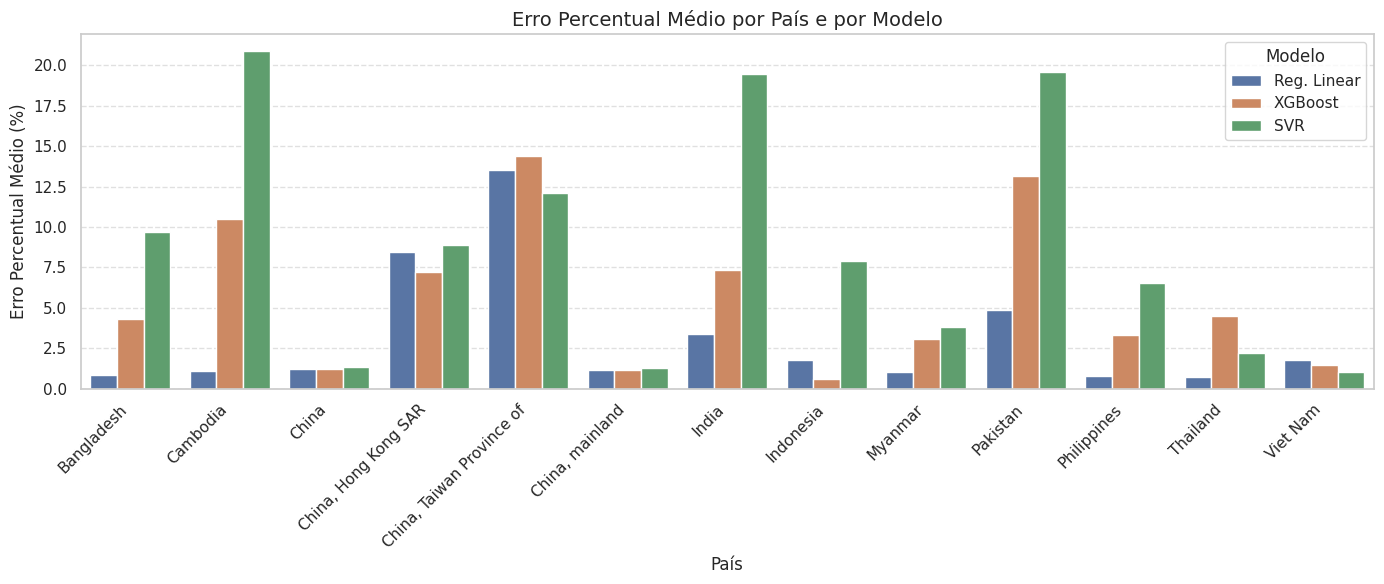

In [ ]:
# Calcular média dos erros percentuais por país
media_erro_por_pais = df_resultado.groupby('Area')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index()

# Visualização com seaborn e matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Reformata para gráfico de barras agrupadas
df_plot_pais = pd.melt(media_erro_por_pais,
                       id_vars='Area',
                       value_vars=['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR'],
                       var_name='Modelo',
                       value_name='Erro Percentual Médio')

# Renomear para legenda mais limpa
df_plot_pais['Modelo'] = df_plot_pais['Modelo'].replace({
    'Erro_%_Prod_LR': 'Reg. Linear',
    'Erro_%_Prod_XGB': 'XGBoost',
    'Erro_%_Prod_SVR': 'SVR'
})

# Gráfico
plt.figure(figsize=(14, 6))
sns.barplot(data=df_plot_pais, x='Area', y='Erro Percentual Médio', hue='Modelo')
plt.title('Erro Percentual Médio por País e por Modelo', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Erro Percentual Médio (%)')
plt.xlabel('País')
plt.legend(title='Modelo')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

,Ano,LR_América do Sul,XGB_América do Sul,SVR_América do Sul,LR_Maiores Produtores,XGB_Maiores Produtores,SVR_Maiores Produtores
0,2021,6.59,6.12,8.94,2.46,5.57,8.61
1,2022,15.36,13.06,16.70,3.11,4.68,7.18
2,2023,9.86,12.22,17.37,3.82,6.41,10.67



Tabela comparativa (% de erro médio):

 Ano LR_América do Sul XGB_América do Sul SVR_América do Sul LR_Maiores Produtores XGB_Maiores Produtores SVR_Maiores Produtores
2021              6.59               6.12               8.94                  2.46                   5.57                   8.61
2022             15.36              13.06              16.70                  3.11                   4.68                   7.18
2023              9.86              12.22              17.37                  3.82                   6.41                  10.67

Arquivos salvos:
- comparacao_erros.csv
- comparacao_erros.png


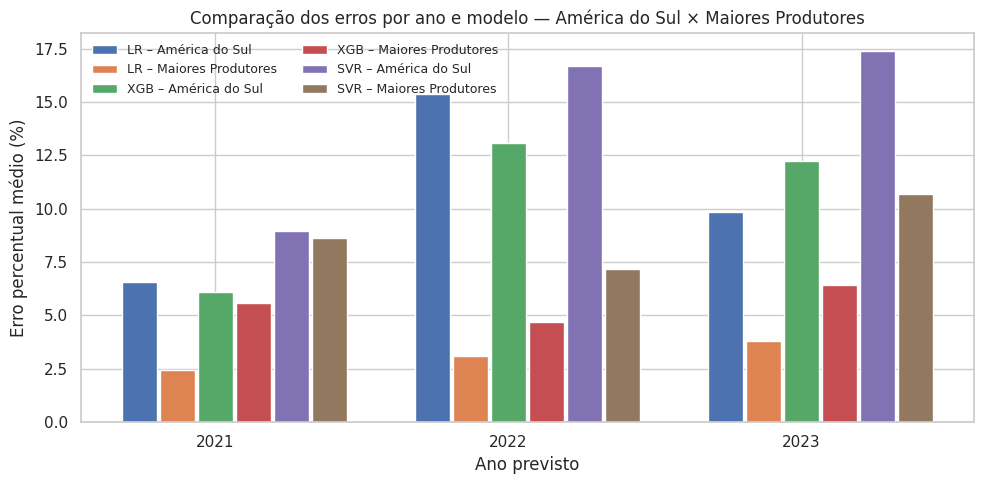

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) Dados (conforme informado)
# -----------------------------
dados_amsul = {
    2021: {"LR": 6.59, "XGB": 6.12, "SVR": 8.94},
    2022: {"LR": 15.36, "XGB": 13.06, "SVR": 16.70},
    2023: {"LR": 9.86, "XGB": 12.22, "SVR": 17.37},
}
dados_top = {
    2021: {"LR": 2.46, "XGB": 5.57, "SVR": 8.61},
    2022: {"LR": 3.11, "XGB": 4.68, "SVR": 7.18},
    2023: {"LR": 3.82, "XGB": 6.41, "SVR": 10.67},
}

# -----------------------------
# 2) Construir DataFrame amplo
# -----------------------------
anos = [2021, 2022, 2023]
linhas = []
for ano in anos:
    linhas.append({
        "Ano": ano,
        "LR_América do Sul": dados_amsul[ano]["LR"],
        "XGB_América do Sul": dados_amsul[ano]["XGB"],
        "SVR_América do Sul": dados_amsul[ano]["SVR"],
        "LR_Maiores Produtores": dados_top[ano]["LR"],
        "XGB_Maiores Produtores": dados_top[ano]["XGB"],
        "SVR_Maiores Produtores": dados_top[ano]["SVR"],
    })
df_comp = pd.DataFrame(linhas)
display(df_comp)

# Salvar CSV
df_comp.to_csv("comparacao_erros.csv", index=False)

# -----------------------------
# 3) Tabela "bonita" no console
# -----------------------------
print("\nTabela comparativa (% de erro médio):\n")
print(df_comp.to_string(index=False, formatters={col: "{:,.2f}".format for col in df_comp.columns if col != "Ano"}))

# -----------------------------
# 4) Gráfico de barras agrupadas
#    (Ano no eixo X; para cada ano, 6 barras: LR/XGB/SVR para cada região)
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 5))

modelos = ["LR", "XGB", "SVR"]
regioes = ["América do Sul", "Maiores Produtores"]

# posições no eixo x
x = np.arange(len(anos))
largura = 0.12  # largura de cada barra
espaco = 0.02   # pequeno espaço entre grupos dentro do ano

# offsets por (modelo,região)
offsets = {
    ("LR", "América do Sul"): -2*largura - espaco,
    ("LR", "Maiores Produtores"): -largura - espaco/2,
    ("XGB", "América do Sul"): 0,
    ("XGB", "Maiores Produtores"): largura + espaco/2,
    ("SVR", "América do Sul"): 2*largura + espaco,
    ("SVR", "Maiores Produtores"): 3*largura + 1.5*espaco,
}

def pega_valores(dados, modelo):
    return [dados[ano][modelo] for ano in anos]

# plotar as 6 séries (3 modelos x 2 regiões)
ax.bar(x + offsets[("LR", "América do Sul")],  pega_valores(dados_amsul, "LR"),  width=largura, label="LR – América do Sul")
ax.bar(x + offsets[("LR", "Maiores Produtores")], pega_valores(dados_top, "LR"), width=largura, label="LR – Maiores Produtores")

ax.bar(x + offsets[("XGB", "América do Sul")],  pega_valores(dados_amsul, "XGB"), width=largura, label="XGB – América do Sul")
ax.bar(x + offsets[("XGB", "Maiores Produtores")], pega_valores(dados_top, "XGB"), width=largura, label="XGB – Maiores Produtores")

ax.bar(x + offsets[("SVR", "América do Sul")],  pega_valores(dados_amsul, "SVR"), width=largura, label="SVR – América do Sul")
ax.bar(x + offsets[("SVR", "Maiores Produtores")], pega_valores(dados_top, "SVR"), width=largura, label="SVR – Maiores Produtores")

# eixos/legendas
ax.set_xticks(x)
ax.set_xticklabels([str(a) for a in anos])
ax.set_xlabel("Ano previsto")
ax.set_ylabel("Erro percentual médio (%)")
ax.set_title("Comparação dos erros por ano e modelo — América do Sul × Maiores Produtores")
ax.legend(ncol=2, fontsize=9, frameon=False)
fig.tight_layout()

# salvar imagem
fig.savefig("comparacao_erros.png", dpi=200, bbox_inches="tight")

print("\nArquivos salvos:")
print("- comparacao_erros.csv")
print("- comparacao_erros.png")